In [1]:
!pip install import-ipynb
import import_ipynb

In [8]:
import import_mpii
#dataset_mpii = import_mpii.dataset
#dataset = dataset_mpii
activities_set = import_mpii.activities_set
#len(dataset_mpii)


train_loader =  import_mpii.train_loader
val_loader = import_mpii.val_loader
test_loader = import_mpii.test_loader

In [9]:
import torch

# Because not 42 🤮
random_state = 137  # 🥰

NUM_EPOCHS = 5

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [10]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 256),  # Adjust input size based on image dimensions after conv layers.
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
def train_model(train_loader, val_loader, test_loader, model_class=SimpleCNN, epochs=NUM_EPOCHS):
    import torch.optim as optim
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    # Assuming you have num_classes
    num_classes = len(activities_set)

    # Initialize the model, loss function, and optimizer
    model = model_class(num_classes=len(activities_set))
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        print("training... 💪")
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):  # Use tqdm for progress bar
            images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)  # Get the predicted class indices
            train_correct += (predicted == labels).sum().item()  # Compare with labels
            train_total += labels.size(0)  # Track the total number of samples

            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate and append training accuracy for this epoch
        train_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_accuracy)

        print("evaluating... ")
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
          for data, target in val_loader:
              # Move data to the selected device
              data, target = data.to(DEVICE), target.to(DEVICE)
              outputs = model(data)
              loss = criterion(outputs, target)
              val_loss += loss.item()

              predicted = torch.argmax(outputs, dim=1)
              total += target.size(0)
              correct += (predicted == target).sum().item()

        val_loss /= len(val_loader)  # Average validation loss
        val_accuracy = 100 * correct / total

        train_losses.append(loss.item()) #for plotting
        val_losses.append(val_loss) #for plotting
        #train_accuracies.append((100 * correct) / total) #for plotting
        val_accuracies.append(val_accuracy) #for plotting

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights =  model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Plot the loss and accuracy curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()
    return best_val_acc

In [ ]:
import torch
torch.cuda.empty_cache()
train_model(train_loader, val_loader, test_loader, model_class=SimpleCNN, epochs=3)

training... 💪
Epoch [1/3], Batch [1/451], Loss: 6.4421


In [8]:
#mimic Big Transfer (BiT)

import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += shortcut
        x = self.relu(x)
        return x

class BiTLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(BiTLikeModel, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Stacking residual blocks
        self.layer1 = self._make_layer(64, 64, num_blocks=3, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=4, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

training... 💪
Epoch [1/50], Batch [1/451], Loss: 6.6995
Epoch [1/50], Batch [51/451], Loss: 5.1619
Epoch [1/50], Batch [101/451], Loss: 5.1105
Epoch [1/50], Batch [151/451], Loss: 4.7515
Epoch [1/50], Batch [201/451], Loss: 5.3574
Epoch [1/50], Batch [251/451], Loss: 4.8927
Epoch [1/50], Batch [301/451], Loss: 5.0020
Epoch [1/50], Batch [351/451], Loss: 5.1215
Epoch [1/50], Batch [401/451], Loss: 4.9601
Epoch [1/50], Batch [451/451], Loss: 5.0299
evaluating... 
Saving best model...💾
Epoch 1/50, Loss: 5.090260747795359
Epoch [1/50], Validation Loss: 7.7234, Validation Accuracy: 5.88%
training... 💪
Epoch [2/50], Batch [1/451], Loss: 4.5553
Epoch [2/50], Batch [51/451], Loss: 4.9986
Epoch [2/50], Batch [101/451], Loss: 4.7765
Epoch [2/50], Batch [151/451], Loss: 4.5020
Epoch [2/50], Batch [201/451], Loss: 4.6635
Epoch [2/50], Batch [251/451], Loss: 4.7845
Epoch [2/50], Batch [301/451], Loss: 4.5675
Epoch [2/50], Batch [351/451], Loss: 4.5571
Epoch [2/50], Batch [401/451], Loss: 4.2229
Epo

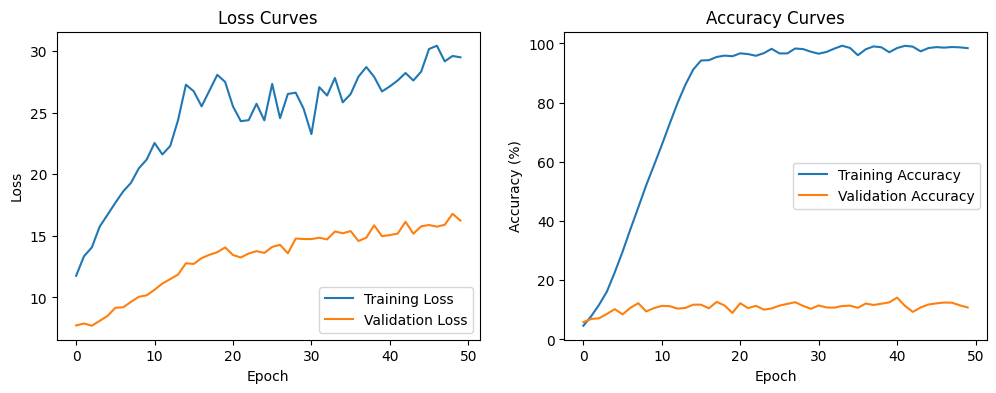

14.143094841930116

In [9]:
import torch
torch.cuda.empty_cache()
train_model(train_loader, val_loader, test_loader, model_class=BiTLikeModel, epochs=50)